# Stats701 Homework 9, Winter 2018
### Mengyi Yuan
#### wendymy@umich.edu

### Problem 1: Warmup: counting words with mrjob
Problem 1 took me 1.5 hours.

In [ ]:
# 1.1

### python script HW9Q1a.py

from mrjob.job import MRJob
import re

WORD_RE = re.compile(r"[\w']+")

class MRWordFrequencyCount(MRJob):
    def mapper(self, _, line):
        for word in WORD_RE.findall(line):
            yield (word.lower(), 1)

    def combiner(self, word, counts):
        yield (word, sum(counts))

    def reducer(self, word, counts):
        yield (word, sum(counts))

if __name__ == "__main__":
    MRWordFrequencyCount.run()

In [5]:
# 1.4
import matplotlib.pyplot as plt
from math import log
%matplotlib inline

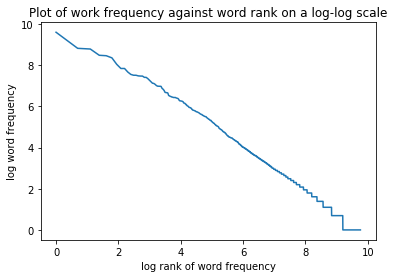

In [3]:
count_lst = []
with open('word_counts.txt') as f:
    for line in f:
        pair = line.split()
        count_lst.append((int(pair[1]),pair[0]))
f.close()

sorted_lst = sorted(count_lst)
rank_lst = list(range(len(sorted_lst), 0, -1))
x = [log(i) for i in rank_lst]
y = [log(j[0]) for j in sorted_lst]
plt.plot(x,y)
plt.xlabel("log rank of word frequency")
plt.ylabel("log word frequency")
plt.title("Plot of work frequency against word rank on a log-log scale")
plt.show()

1.5

The plot looks approximately like a line, especially in the middle part of the plot. 

### Problem 2: Computing Sample Statistics with mrjob
Problem 2 took me 1.5 hours.

In [ ]:
# 2.1

### mr_summary_stats.py

from mrjob.job import MRJob
import functools

class MRSummaryStats(MRJob):
    
    def mapper(self, _, line):
        label_value = line.split()
        yield (int(label_value[0]), [float(label_value[1]), float(label_value[1])**2, 1])

    def reducer(self, label, value_lst):
        summary_stats = functools.reduce(lambda x,y: [x[0]+y[0],x[1]+y[1],x[2]+y[2]], value_lst)
        yield (label, [summary_stats[2], summary_stats[0]/summary_stats[2],
                       summary_stats[1]/summary_stats[2]-(summary_stats[0]/summary_stats[2])**2])


if __name__ == "__main__":
    MRSummaryStats.run()

In [11]:
stats_lst

[[0.0, 834237.0, 11.562434283892557, 87499013.8387025],
 [1.0, 833777.0, 22.067051460814614, 92621488.47560832],
 [10.0, 834949.0, 2.8455360916440164, 105563887.98123512],
 [11.0, 832304.0, 34.5728640569971, 79515773.7313861],
 [2.0, 832451.0, 14.857210333720584, 87338145.96809214],
 [3.0, 832676.0, 19.11766927764743, 81581436.87580727],
 [4.0, 833149.0, 15.099974508256016, 92922667.45568337],
 [5.0, 831961.0, 6.847776079634745, 105528024.59797779],
 [6.0, 833335.0, 3.556395959278101, 61423963.19379812],
 [7.0, 834354.0, 4.798076383114637, 85288463.9603821],
 [8.0, 833649.0, 15.778497492611915, 86666981.67259522],
 [9.0, 833158.0, 8.631111917292886, 72319972.96810105]]

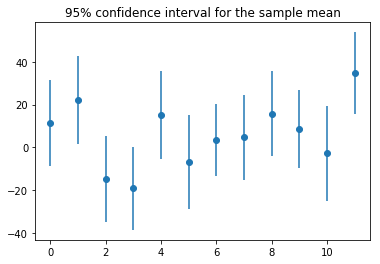

In [13]:
# 2.4
from scipy.stats import norm
import re

z_alpha = norm.ppf(0.975)
stats_lst = []
with open('summary_large.txt') as f:
    for line in f:
        values = [float(i) for i in re.findall("[-0-9\.]+", line)]
        stats_lst.append(values)
f.close()

x = [int(i[0]) for i in stats_lst]
mean = [i[2] for i in stats_lst]
margin_of_error = [z_alpha*(i[3]/i[1])**0.5 for i in stats_lst]

plt.errorbar(x, mean, yerr = margin_of_error, fmt="o")
plt.title("95% confidence interval for the sample mean")
plt.show()

### Problem 3: Graph Processing: Counting Triangles with PySpark
Problem 3 took me 3 hours.

In [ ]:
# 3.1

### HW9Q3.py

from pyspark import SparkConf, SparkContext
import sys

# This script takes two arguments, an input and output
if len(sys.argv) != 3:
    print('Usage: ' + sys.argv[0] + ' <in><out>')
    sys.exit(1)
    
inputlocation = sys.argv[1]
outputlocation = sys.argv[2]

# Set up the configuration and job context
conf = SparkConf().setAppName('Summation')
sc = SparkContext(conf=conf)

# Read in the dataset and immediately transform all the lines in array
data = sc.textFile(inputlocation).map(lambda line: line.split())
data = data.map(lambda x: [int(i) for i in x])
data = data.flatMap(lambda x: [sorted((x[0],x[i],x[j])) for i in range(1, len(x)) for j in range(1, len(x)) if i < j])

data = data.map(lambda x: (tuple(x),1))
data_count = data.reduceByKey(lambda x,y: x+y)
data_final = data_count.filter(lambda x: x[1]>=2).keys()

# Save the results in the specified output directory
data_final.saveAsTextFile(outputlocation)
sc.stop()

There are 6 triangles in the list.